# King County Housing Regression Project

## Table Of Contents
<font size=3rem>
    
0 -**[ INTRO](#INTRODUCTION)<br>**
1 -**[ OBTAIN](#OBTAIN)**<br>
2 -**[ SCRUB](#SCRUB)**<br>
3 -**[ EXPLORE](#EXPLORE)**<br>
4 -**[ MODEL](#MODEL)**<br>
5 -**[ INTERPRET](#INTERPRET)**<br>
6 -**[ CONCLUSIONS & RECCOMENDATIONS](#Conclusions-&-Recommendations)<br>**
</font>
___

# INTRODUCTION

* Students: Cody Freese/Fennec Nightingale/Thomas Cornett
* Pace: Part time
* Instructor: Amber Yandow
* Blog post URL:

<p> What factors impact the price of a home?</p>
<p> What factors impact the price of a home for different income levels?</p>
<p> If you're looking to move your family to king county, where is the best bang for your buck?</p>

## Import Tools

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import mlxtend

In [2]:
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [3]:
from math import sin, cos, sqrt, atan2, radians
from sklearn import svm
from scipy.stats import zscore
from sklearn import linear_model
from statsmodels.formula.api import ols
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import cross_val_predict, KFold, train_test_split
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from statsmodels.stats.outliers_influence import variance_inflation_factor

### Editing Our Settings 
We have too many columns to view normally, and it's difficult to get a good grasp of our data with how much is normally cut off. 


In [4]:
%matplotlib inline
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### Define functions 

In [ ]:
def getClosest(home_lat: float, home_lon: float, dest_lat_series: 'series', dest_lon_series: 'series'):
    """Pass 1 set of coordinates and one latitude or longitude column you would like to compare it's distance to"""
    #radius of the earth in miles 
    r = 3963
    #setting variables to use to iterate through  
    closest = 100
    within_mile = 0
    i = 0
    #using a while loop to iterate over our data and calculate the distance between each datapoint and our homes 
    while i < dest_lat_series.size:
        lat_dist = radians(home_lat) - (dest_lat := radians(dest_lat_series.iloc[i]))
        lon_dist = radians(home_lon) - (radians(dest_lon_series.iloc[i]))
        a = sin(lat_dist / 2)**2 + cos(radians(home_lat)) * cos(radians(dest_lat)) * sin(lon_dist / 2)**2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))
        c = r * c 
        #find the closest data to our homes by keeping our smallest (closest) value
        if (c < closest):
            closest = c
        #find all of the points that fall within one mile and count them 
        if (c <= 1.0):
            within_mile += 1
        i += 1
    return [closest, within_mile]

In [579]:
def plotcoef(model):
    """Takes in OLS results and returns a plot of the coefficients"""
    #make dataframe from summary of results 
    coef_df = pd.DataFrame(model.summary().tables[1].data)
    #rename your columns
    coef_df.columns = coef_df.iloc[0]
    #drop header row 
    coef_df = coef_df.drop(0)
    #set index to variables
    coef_df = coef_df.set_index(coef_df.columns[0])
    #change dtype from obj to float
    coef_df = coef_df.astype(float)
    #get errors
    err = coef_df['coef'] - coef_df['[0.025']
    #append err to end of dataframe 
    coef_df['errors'] = err
    #sort values for plotting 
    coef_df = coef_df.sort_values(by=['coef'])
    ## plotting time ##
    var = list(coef_df.index.values)
    #add variables column to dataframe 
    coef_df['var'] = var
    # define fig 
    fig, ax = plt.subplots(figsize=(8,5))
    #error bars for 95% confidence interval
    coef_df.plot(x='var', y='coef', kind='bar',
                ax=ax, fontsize=20, yerr='errors')
    #set title and label 
    plt.title('Coefficients of Features With 95% Confidence Interval', fontsize=30)
    ax.set_ylabel('Coefficients', fontsize=20)
    ax.set_xlabel(' ')
    #coefficients 
    ax.scatter(x= np.arange(coef_df.shape[0]),
              marker='o', s=80, 
              y=coef_df['coef'])
    return plt.show()

In [594]:
def make_ols(df, x_columns, target='price'):
    """Pass in a DataFrame & your predictive columns to return an OLS regression model """
    #set your x and y variables
    X = df[x_columns]
    y = df[target]
    # pass them into stats models OLS package
    ols = sm.OLS(y, X)
    #fit your model
    model = ols.fit()
    #display the model summarry
    display(model.summary())
    #plot the residuals 
    fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', alpha=.05, fit=True)
    #return model for later use 
    return model

# OBTAIN DATA
Here we'll be working with the King County housing data provided to us by FlatIron and data about schools in King County gathered by ArcGis. We'll be importing them via the Pandas library. 

In [5]:
#wrote up our data types to save on computer space and stop some of them from being inccorectly read as objs
kc_dtypes = {'id': int, 'date' : str,  'price': float, 'bedrooms' : int, 'bathrooms' : float, 'sqft_living': int, 'sqft_lot': int, 
             'floors': float, 'waterfront': float, 'view' : float, 'condition': float, 'grade': int, 'sqft_above': int, 
             'yr_built': int, 'yr_renovated': float, 'zipcode': float, 'lat': float, 'long': float}

In [6]:
kc_data = pd.read_csv(r'~\Documents\Flatiron\data\data\kc_house_data.csv', parse_dates = ['date'], dtype=kc_dtypes)
schools = pd.read_csv(r'~\Documents\Flatiron\data\data\Schools.csv')
foods = pd.read_csv(r'~\Documents\Flatiron\foods.csv')

In [8]:
foods = foods.loc[foods['lat'] != '[0.0]'].copy()
foods = foods.loc[foods['long'] != '[0.0]'].copy()
foods['lat'] = foods['lat'].astype(dtype=float)
foods['long'] = foods['long'].astype(dtype=float)

In [9]:
rest = foods.loc[foods['SEAT_CAP'] != 'Grocery']
groc = foods.loc[foods['SEAT_CAP'] == 'Grocery']

In [10]:
kc_dict = {}

In [11]:
i = 0
while i < kc_data['lat'].size:
    school = getClosest(kc_data['lat'].iloc[i], kc_data['long'].iloc[i], schools['LAT_CEN'], schools['LONG_CEN'])
    restaurant = getClosest(kc_data['lat'].iloc[i], kc_data['long'].iloc[i], rest['lat'], rest['long'])
    grocery = getClosest(kc_data['lat'].iloc[i], kc_data['long'].iloc[i], groc['lat'], groc['long'])
    kc_dict[i] = {
        "closest school": school[0],
        "schools within mile": school[1],
        "closest restaurant": restaurant[0],
        "restaurants within mile": restaurant[1],
        "closest grocery": grocery[0],
        "groceries within mile": grocery[1]}
    i += 1 

In [12]:
rest

,Unnamed: 0,NAME,SEAT_CAP,long,lat
1,1,A-Chau Cafe,Seating 13-50,-122.271193,47.540560
2,2,A-Pizza Mart,Seating 0-12,-122.376392,47.517716
3,3,A & B Cafe; Inc.,Seating 13-50,-122.324081,47.597627
4,4,A & H World Market,Seating 0-12,-122.286187,47.389257
5,5,A & J Meats & Seafood,Meat/Sea Food,-122.357325,47.639730
...,...,...,...,...,...
2330,2330,Bleu Bistor'S Grotto,Seating 13-50,-122.321921,47.619794
2331,2331,Blue Island Roll & Sushi,Seating 51-150,-122.317919,47.288160
2333,2333,Black Rock Coffee Bar,Seating 0-12,-122.345632,47.732773
2334,2334,Bon - Appetit @ Cornish College,Non-Profit Institution,-122.336233,47.618196


That's all of the data we need to start. Now we'll be adding the last of our data, calculating the distance between the schools and our homes. 

In [ ]:
#calculate distance between schools and data 
kc = {}
kc_scl = {}
kc_rest = {}
kc_groc = {}


i = 0
#iterate over each of our rows in the dataframe
while i <= 21480:
    k = 0
    j = 0
    l = 0 
    # approximate radius of earth in miles 
    R = 3963.0
    lat1 = radians(kc_data['lat'].iloc[i])
    lon1 = radians(kc_data['long'].iloc[i])
    scl_distance = []
    groc_distance = []
    rest_distance = []
    scl_count =  0
    rest_count = 0
    groc_count = 0

    #iterate over each school to see which school is the closest to each row in our datframe 
    while k <= 641:
        lat2 = radians(schools['LAT_CEN'].iloc[k])
        lon2 = radians(schools['LONG_CEN'].iloc[k])
        dlon = lon2 - lon1
        dlat = lat2 - lat1
        a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))
        scl_distance.append(R * c)
        k += 1 
    #while we're here, we're also going to iterate through food places nearby 
    while j <= 177:
        lat2 = radians(groc['LAT'].iloc[j])
        lon2 = radians(groc['LONG'].iloc[j])
        dlon = lon2 - lon1
        dlat = lat2 - lat1
        a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))
        groc_distance.append(R * c)
        j += 1 
        
    while l <= 2158:
        lat2 = radians(rest['LAT'].iloc[l])
        lon2 = radians(rest['LONG'].iloc[l])
        dlon = lon2 - lon1
        dlat = lat2 - lat1
        a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))
        rest_distance.append(R * c)
        l += 1     
    
    #sort schools by distance 
    scl_distance.sort()
    #choose closest school 
    kc[i] = scl_distance[0:1]
    #count how many schools are in a miles radius 
    for m in scl_distance : 
        if m <= 1.0 : 
            scl_count = scl_count + 1
    kc_scl[i] = scl_count 
    for n in rest_distance : 
        if n <= 1.0 : 
            rest_count = rest_count + 1
    kc_rest[i] = rest_count 
    for o in groc_distance : 
        if o <= 1.0 : 
            groc_count = groc_count + 1
    kc_groc[i] = groc_count 
    i += 1

Now we turn those distances into a dataframe, so we can join them with the rest of our data and match them with the houses they belong to. 

In [14]:
kc = pd.DataFrame.from_dict(kc_dict, orient='index')
kc_data = kc_data.merge(kc, left_index=True, right_index=True)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,closest school,schools within mile,closest restaurant,restaurants within mile,closest grocery,groceries within mile
0,-1460634072,2014-10-13,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,3.0,7,1180,0.0,1955,0.0,98178.0,47.5112,-122.257,1340,5650,0.158521,4,0.631405,9,0.810740,1
1,2119132896,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3.0,7,2170,400.0,1951,1991.0,98125.0,47.7210,-122.319,1690,7639,0.297979,7,0.448437,12,1.188117,0
2,1336533104,2015-02-25,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3.0,6,770,0.0,1933,NaN,98028.0,47.7379,-122.233,2720,8062,0.131574,3,0.871636,2,2.338788,0
3,-1807766421,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5.0,7,1050,910.0,1965,0.0,98136.0,47.5208,-122.393,1360,5000,1.164844,0,0.145426,3,1.620475,0
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3.0,8,1680,0.0,1987,0.0,98074.0,47.6168,-122.045,1800,7503,0.761622,3,0.502789,8,0.659518,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,2014-05-21,360000.0,3,2.50,1530,1131,3.0,0.0,0.0,3.0,8,1530,0.0,2009,0.0,98103.0,47.6993,-122.346,1530,1509,0.426824,6,0.079656,28,0.637029,4
21593,-1989874472,2015-02-23,400000.0,4,2.50,2310,5813,2.0,0.0,0.0,3.0,8,2310,0.0,2014,0.0,98146.0,47.5107,-122.362,1830,7200,0.451125,8,0.609375,13,0.828467,2
21594,1523300141,2014-06-23,402101.0,2,0.75,1020,1350,2.0,0.0,0.0,3.0,7,1020,0.0,2009,0.0,98144.0,47.5944,-122.299,1020,2007,0.242924,8,0.158903,23,0.695331,2
21595,291310100,2015-01-16,400000.0,3,2.50,1600,2388,2.0,NaN,0.0,3.0,8,1600,0.0,2004,0.0,98027.0,47.5345,-122.069,1410,1287,1.350470,0,1.281635,0,1.468392,0


Now let's take a look at our data to see what we are working with and what we might need to fix 

In [43]:
kc_data = kc_data.rename(columns ={'closest school': 'mi_2_scl', 'schools within mile': 'scls_in_mi', 'closest restaurant':'mi_2_rest', 
                          'restaurants within mile':'rest_in_mi','closest grocery': 'mi_2_groc', 'groceries within mile': 'groc_in_mi'})

In [44]:
kc_data.isnull().sum()

Unnamed: 0          0
id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
mi_2_scl            0
scls_in_mi          0
mi_2_rest           0
rest_in_mi          0
mi_2_groc           0
groc_in_mi          0
dtype: int64

# SCRUB
Cleaning up our data, filling NaN values, dropping unnecessary columns 

In [45]:
kc_data = kc_data.drop(['id', 'date'], 1)

In [46]:
#to use sqft basment later on we need to convert it to a float 
kc_data['sqft_basement'] = kc_data['sqft_basement'].replace({'?': 0})
kc_data['sqft_basement'] = kc_data['sqft_basement'].astype(dtype=float)

As we can see we have 3 columns with null values, after exploring them, it makes the most sense to fill the null values with zeros, which is what they had been using to indicate a column without anything anyways. 

In [47]:
kc_data = kc_data.fillna(0)

In [48]:
#Convert to integer for whole number year, not sure why it'll let us reassign it here but raise errors in dtypes
kc_data['yr_renovated'] = kc_data['yr_renovated'].astype('int')

### Add Dummy Variables<p>
Catagorical columns needs to be transformed so we can use them in our model.</p>
<p>
thankfully, the Pandas library has got us covered with pd.get_dummies()</p>

In [49]:
# fixing condition to be a good or bad, hoping that'll help get rid of the multicolinearity 
kc_data['condition'] = kc_data.condition.replace(to_replace = [1.0, 2.0, 3.0, 4.0, 5.0],  value= ['bad', 'bad', 'good', 'good', 'good'])

In [50]:
#we have 70 zipcodes and 120 years, it would add too much complexity to our data to increase it by 190 columns
# so instead, we're going to go through and bin them! 
zips = []
years = []


for zipcode in kc_data.zipcode:
    zips.append(zipcode)
for year in kc_data.yr_built:
    years.append(year)
    
zips = list(set(zips))
years = list(set(years))

zips.sort()
years.sort()

In [51]:
#will have to find a way to write this into a loop at some point, but, I can't figure out how to get .replace()
#to adequatley read lists of lists while also giving them unique names, so for now this works 
kc_data['zipcode'] = kc_data.zipcode.replace(to_replace = zips[0:5],  value= 'zip001t005')
kc_data['zipcode'] = kc_data.zipcode.replace(to_replace = zips[5:10], value= 'zip006t011')
kc_data['zipcode'] = kc_data.zipcode.replace(to_replace = zips[10:15], value= 'zip014t024')
kc_data['zipcode'] = kc_data.zipcode.replace(to_replace = zips[15:20], value= 'zip027t031')
kc_data['zipcode'] = kc_data.zipcode.replace(to_replace = zips[20:25], value= 'zip032t039')
kc_data['zipcode'] = kc_data.zipcode.replace(to_replace = zips[25:30], value= 'zip040t053')
kc_data['zipcode'] = kc_data.zipcode.replace(to_replace = zips[30:35], value= 'zip055t065')
kc_data['zipcode'] = kc_data.zipcode.replace(to_replace = zips[35:40], value= 'zip070t077')
kc_data['zipcode'] = kc_data.zipcode.replace(to_replace = zips[40:45], value= 'zip092t106')
kc_data['zipcode'] = kc_data.zipcode.replace(to_replace = zips[45:50], value= 'zip107t115')
kc_data['zipcode'] = kc_data.zipcode.replace(to_replace = zips[50:55], value= 'zip116t122')
kc_data['zipcode'] = kc_data.zipcode.replace(to_replace = zips[55:60], value= 'zip125t144')
kc_data['zipcode'] = kc_data.zipcode.replace(to_replace = zips[60:65], value= 'zip146t168')
kc_data['zipcode'] = kc_data.zipcode.replace(to_replace = zips[65:70], value= 'zip177t199')

In [52]:
#gonna do the same for year built by 20 years, will give us 6 new columns, may be illuminating 
kc_data['yr_built'] = kc_data.yr_built.replace(to_replace = years[0:20], value= 'thru20')
kc_data['yr_built'] = kc_data.yr_built.replace(to_replace = years[20:40], value= 'thru40')
kc_data['yr_built'] = kc_data.yr_built.replace(to_replace = years[40:60], value= 'thru60')
kc_data['yr_built'] = kc_data.yr_built.replace(to_replace = years[60:80], value= 'thru80')
kc_data['yr_built'] = kc_data.yr_built.replace(to_replace = years[80:100], value= 'thru2000')
kc_data['yr_built'] = kc_data.yr_built.replace(to_replace = years[100:120], value= 'thru2020')

In [53]:
# get dummies of our new variables 
dummys = ['zipcode', 'yr_built', 'condition', ]

for dummy in dummys:
    dumm = pd.get_dummies(kc_data[dummy], drop_first=True)
    kc_data = kc_data.merge(dumm, left_index=True, right_index=True)

#we're doing something unique to these variables so it wouldn't save us any time to put them into a loop
dumm = pd.get_dummies(kc_data['view'], prefix='view', drop_first=True, dtype=int)
kc_data = kc_data.merge(dumm, left_index=True, right_index=True)
dumm = pd.get_dummies(kc_data['grade'], prefix='gra', drop_first=True, dtype=int)
kc_data = kc_data.merge(dumm, left_index=True, right_index=True)

In [54]:
#break up variables into diverse ranges & renaming our dummies so that they'r easier to interpret 
kc_data = kc_data.rename({'view_1.0': 'view1', 'view_2.0': 'view2', 'view_3.0': 'view3', 'view_4.0':'view4'},axis=1)
kc_data = kc_data.rename({'gra_4': 'D', 'gra_5':'Cmin', 'gra_6':'C','gra_7':'Cpl', 'gra_8':'Bmin', 'gra_9':'B',
                          'gra_10':'Bpl', 'gra_11':'Amin', 'gra_12':'A', 'gra_13':'Apl'},axis=1)

# EXPLORE

Now that we have all of the data we'll need ready to go we can really start digging in and checking it out! 

## Histogram

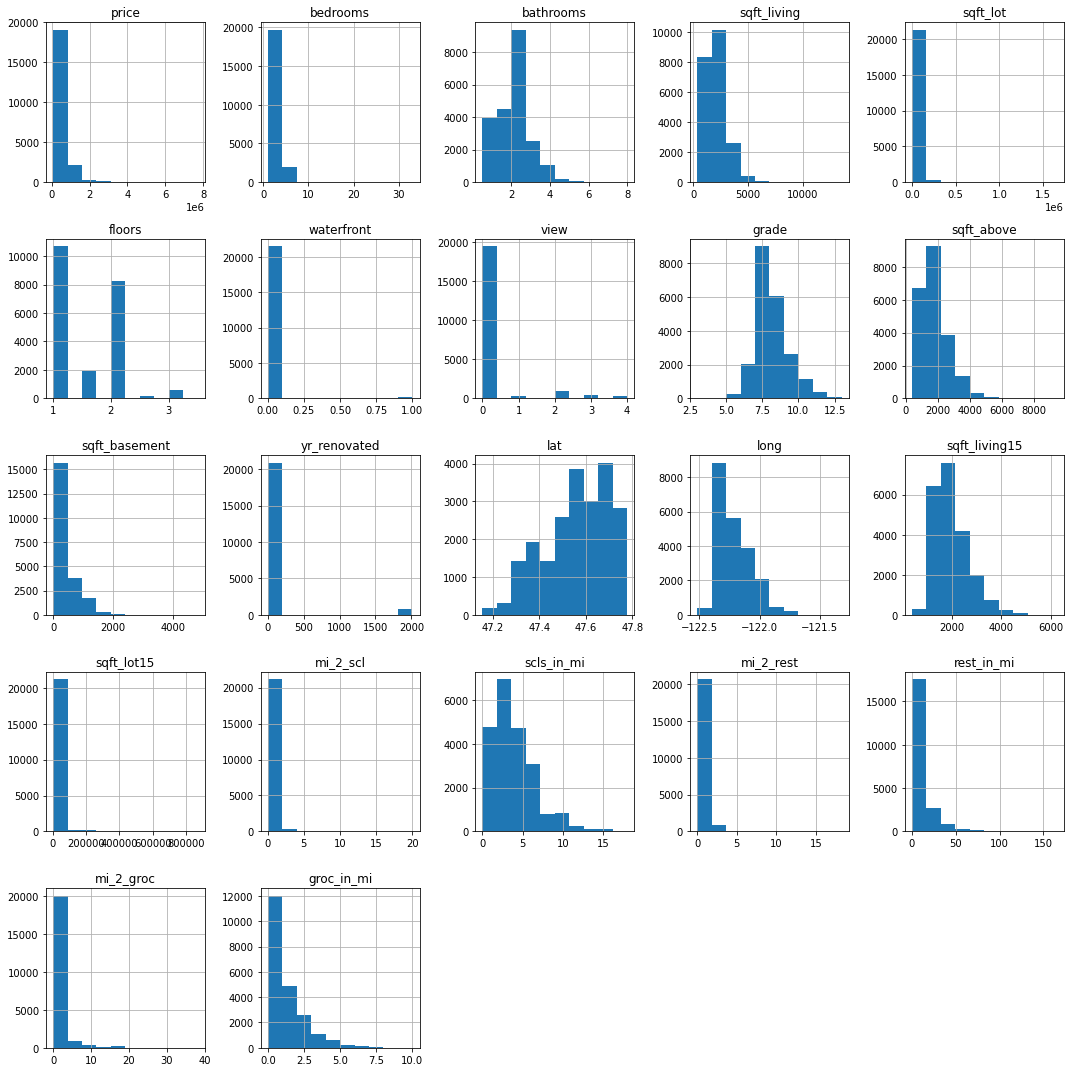

In [62]:
hist = kc_data[['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view',
                'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 
                'lat', 'long', 'sqft_living15', 'sqft_lot15', 'mi_2_scl', 'scls_in_mi', 'mi_2_rest',
                'rest_in_mi', 'mi_2_groc', 'groc_in_mi']]
hist.hist(figsize=(15,15))
plt.tight_layout()

## Scatter Matrix

In [68]:
# fig = pd.plotting.scatter_matrix(kc_data,figsize=(16,16));
kc_data.columns

Index(['Unnamed: 0', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'mi_2_scl', 'scls_in_mi', 'mi_2_rest', 'rest_in_mi', 'mi_2_groc', 'groc_in_mi', 'zip006t011', 'zip014t024', 'zip027t031', 'zip032t039', 'zip040t053', 'zip055t065', 'zip070t077', 'zip092t106', 'zip107t115', 'zip116t122', 'zip125t144', 'zip146t168', 'zip177t199', 'thru2000', 'thru2020', 'thru40', 'thru60', 'thru80', 'good', 'view1', 'view2', 'view3', 'view4', 'D', 'Cmin', 'C', 'Cpl', 'Bmin', 'B', 'Bpl', 'Amin', 'A', 'Apl'], dtype='object')

## Heatmap

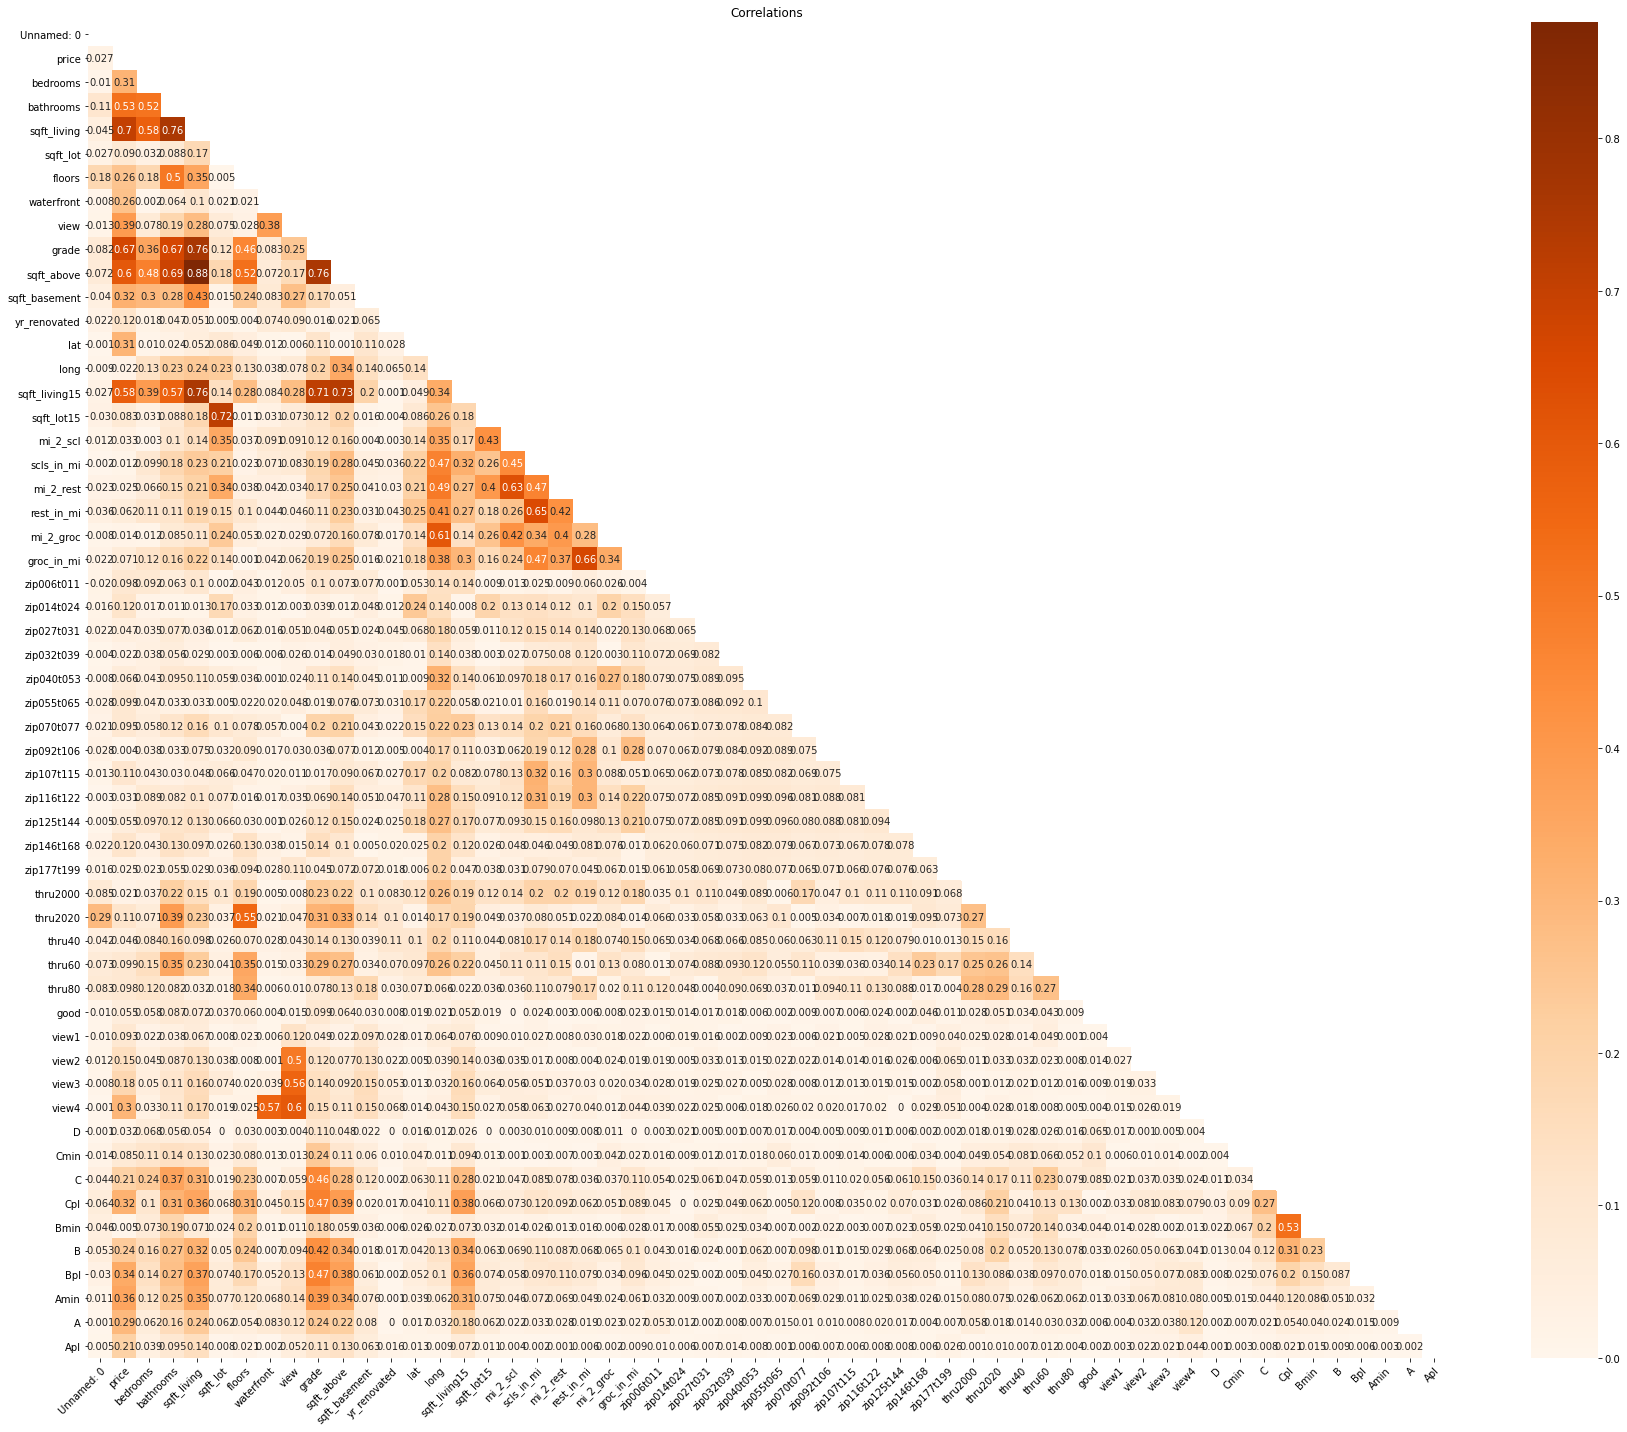

In [66]:
fig, ax = plt.subplots(figsize=(25,20))
corr = kc_data.corr().abs().round(3)
mask = np.triu(np.ones_like(corr, dtype=np.bool))
sns.heatmap(corr, annot=True, mask=mask, cmap='Oranges', ax=ax)
plt.setp(ax.get_xticklabels(), 
         rotation=45, 
         ha="right",
         rotation_mode="anchor")
ax.set_title('Correlations')
fig.tight_layout()

We can see some colinearity between our features, it's best to either remove or transform them if we want to use them in our model

If we were to multiply by basement to try and get rid of the correlation, we'd be multiplying by a bunch of zeros and it wouldn't adequetly represent our data. By adding one to every 'sqft_basement' that is equal to zero, when we multiply if there are no basement values we still keep our 'sqft_above' values. 

In [67]:
kc_data['sqft_basement'] = kc_data['sqft_basement'].map(lambda x :  1 if x == 0 else x )

In [70]:
#getting rid of multicolinearity in sqftage 
kc_data['sqft_total'] = kc_data['sqft_living']*kc_data['sqft_lot']
kc_data['sqft_neighb'] = kc_data['sqft_living15']*kc_data['sqft_lot15']
kc_data['sqft_habitable'] = kc_data['sqft_above']*kc_data['sqft_basement']

In [71]:
#print columns we will be using going forward 
#make a copy of the dataframe holding only columns we'll be including
kc_data.columns
all_data = kc_data.copy()
kc_data = kc_data[['price', 'bedrooms', 'bathrooms', 'floors','waterfront', 
                   'yr_renovated', 'lat', 'long', 
                   'sqft_total', 'sqft_neighb', 'sqft_habitable', 
                   'good', 'view1', 'view2', 'view3', 'view4', 
                   'D', 'Cmin', 'C', 'Cpl', 'Bmin', 'B', 'Bpl', 'Amin', 
                   'zip006t011', 'zip014t024', 'zip027t031', 'zip032t039', 
                   'zip040t053', 'zip055t065', 'zip070t077', 'zip092t106', 
                   'zip107t115', 'zip116t122', 'zip125t144', 'zip146t168', 
                   'zip177t199', 
                   'thru2000', 'thru2020', 'thru40', 'thru60', 'thru80',
                   'mi_2_scl', 'scls_in_mi', 'mi_2_rest', 'rest_in_mi', 'mi_2_groc', 'groc_in_mi']].copy()

# MODEL

## Initial Model on Price

In [77]:
lowtier = kc_data[kc_data.price <=300000]
midtier = kc_data[(kc_data.price > 300001) & (kc_data.price<=800000) ]
hightier = kc_data[kc_data.price >800000]

lowincome = ['bedrooms', 'bathrooms', 'floors', 'waterfront', 
          'yr_renovated', 'lat', 'long', 
          'sqft_total', 'sqft_neighb', 'sqft_habitable', 
          'good', 'view1', 'view2', 'view3', 'view4', 
          'D', 'Cmin', 'C', 'Cpl', 'Bmin', 'B', 'Bpl', 'Amin',  
          'zip006t011', 'zip014t024', 'zip027t031', 'zip032t039', 
          'zip040t053', 'zip055t065', 'zip070t077', 'zip092t106', 
          'zip107t115', 'zip116t122', 'zip125t144', 'zip146t168', 
          'zip177t199', 
          'thru2000', 'thru2020', 'thru40', 'thru60', 'thru80',
          'mi_2_scl', 'scls_in_mi', 'mi_2_rest', 'rest_in_mi', 'mi_2_groc', 'groc_in_mi']

mediumincome = ['bedrooms', 'bathrooms', 'floors', 'waterfront', 
          'yr_renovated', 'lat', 'long', 
          'sqft_total', 'sqft_neighb', 'sqft_habitable', 
          'good', 'view1', 'view2', 'view3', 'view4', 
          'D', 'Cmin', 'C', 'Cpl', 'Bmin', 'B', 'Bpl', 'Amin',  
          'zip006t011', 'zip014t024', 'zip027t031', 'zip032t039', 
          'zip040t053', 'zip055t065', 'zip070t077', 'zip092t106', 
          'zip107t115', 'zip116t122', 'zip125t144', 'zip146t168', 
          'zip177t199', 
          'thru2000', 'thru2020', 'thru40', 'thru60', 'thru80',
          'mi_2_scl', 'scls_in_mi', 'mi_2_rest', 'rest_in_mi', 'mi_2_groc', 'groc_in_mi']

highincome = ['bedrooms', 'bathrooms', 'floors', 'waterfront', 
          'yr_renovated', 'lat', 'long', 
          'sqft_total', 'sqft_neighb', 'sqft_habitable', 
          'good', 'view1', 'view2', 'view3', 'view4', 
          'D', 'Cmin', 'C', 'Cpl', 'Bmin', 'B', 'Bpl', 'Amin',  
          'zip006t011', 'zip014t024', 'zip027t031', 'zip032t039', 
          'zip040t053', 'zip055t065', 'zip070t077', 'zip092t106', 
          'zip107t115', 'zip116t122', 'zip125t144', 'zip146t168', 
          'zip177t199', 
          'thru2000', 'thru2020', 'thru40', 'thru60', 'thru80',
          'mi_2_scl', 'scls_in_mi', 'mi_2_rest', 'rest_in_mi', 'mi_2_groc', 'groc_in_mi']

In [79]:
price_tiers = [('low', lowtier, lowincome), 
               ('mid', midtier, mediumincome), 
               ('high', hightier, highincome)]

In [583]:
for name, tier, income in price_tiers:
    print(name.upper())
    make_ols(tier, income)

SyntaxError: invalid syntax (<ipython-input-583-e8d88944c23c>, line 1)

## Refinement
First we're going to start filtering out outliers, helping normalize our data should improve our model 

In [81]:
for col in ['price']:
    col_zscore = str(col + '_zscore')
    kc_data[col_zscore] = (kc_data[col] - kc_data[col].mean())/kc_data[col].std()
    kc_data = kc_data.loc[kc_data[col_zscore] < 2]
    kc_data = kc_data.loc[kc_data[col_zscore] > (-2)]
    kc_data = kc_data.drop(col_zscore, axis = 1)

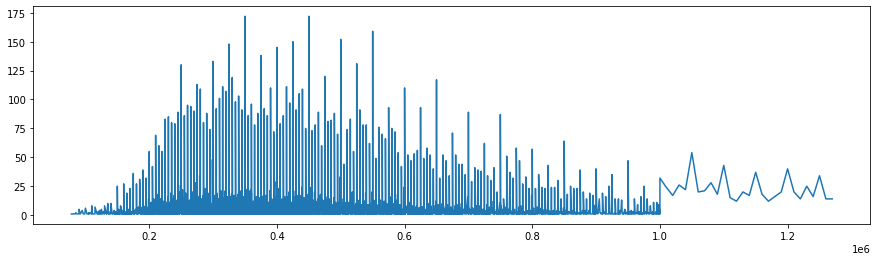

In [82]:
plt.figure(figsize=(15,4))
plt.plot(kc_data['price'].value_counts().sort_index())

In [83]:
for i in range(1,100):
    q = i / 100
    print('{} percentile: {}'.format(q, kc_data['price'].quantile(q=q)))

0.01 percentile: 152720.0
0.02 percentile: 175000.0
0.03 percentile: 190000.0
0.04 percentile: 200000.0
0.05 percentile: 210000.0
0.06 percentile: 218000.0
0.07 percentile: 225000.0
0.08 percentile: 230000.0
0.09 percentile: 238000.0
0.1 percentile: 245000.0
0.11 percentile: 249902.5
0.12 percentile: 253000.0
0.13 percentile: 259000.0
0.14 percentile: 264500.0
0.15 percentile: 269000.0
0.16 percentile: 274000.0
0.17 percentile: 278500.0
0.18 percentile: 282000.0
0.19 percentile: 288000.0
0.2 percentile: 293000.0
0.21 percentile: 299000.0
0.22 percentile: 301000.0
0.23 percentile: 307000.0
0.24 percentile: 312000.0
0.25 percentile: 317000.0
0.26 percentile: 322000.0
0.27 percentile: 325000.0
0.28 percentile: 330000.0
0.29 percentile: 335000.0
0.3 percentile: 340000.0
0.31 percentile: 345000.0
0.32 percentile: 350000.0
0.33 percentile: 353000.0
0.34 percentile: 358350.00000000035
0.35 percentile: 363000.0
0.36 percentile: 369950.0
0.37 percentile: 375000.0
0.38 percentile: 379900.0
0.39 

In [84]:
#in bedrooms, we can clearly see a single outlier that is likely just a typo 
kc_data[kc_data['bedrooms'] == 33]
# wouldn't be realistic for a house with 33 bedrooms to only have a sqft_living of 1620 and only 1 3/4 bathrooms so we will adjust to 3 
kc_data[kc_data['bedrooms'] == 33] = kc_data[kc_data['bedrooms'] == 33].replace(33,3)

In [91]:
# to fix other outliers we will explore our data and find cutoffs that seem reasonable 
kc_data = kc_data.loc[kc_data['sqft_total'] <= 1.000000e+09] 
kc_data = kc_data.loc[kc_data['sqft_total'] >= 400000]
kc_data = kc_data.loc[kc_data['sqft_neighb'] <= 1.000000e+09]
kc_data = kc_data.loc[kc_data['sqft_habitable'] >= 400000]
kc_data = kc_data.loc[kc_data['sqft_habitable'] <= 1.000000e+07]
kc_data =  kc_data.loc[kc_data['bathrooms'] >= 1]
kc_data =  kc_data.loc[kc_data['bathrooms'] <= 5]
kc_data =  kc_data.loc[kc_data['bedrooms'] <= 7]
kc_data.columns

Index(['price', 'bedrooms', 'bathrooms', 'floors', 'waterfront', 'yr_renovated', 'lat', 'long', 'sqft_total', 'sqft_neighb', 'sqft_habitable', 'good', 'view1', 'view2', 'view3', 'view4', 'D', 'Cmin', 'C', 'Cpl', 'Bmin', 'B', 'Bpl', 'Amin', 'zip006t011', 'zip014t024', 'zip027t031', 'zip032t039', 'zip040t053', 'zip055t065', 'zip070t077', 'zip092t106', 'zip107t115', 'zip116t122', 'zip125t144', 'zip146t168', 'zip177t199', 'thru2000', 'thru2020', 'thru40', 'thru60', 'thru80', 'mi_2_scl', 'scls_in_mi', 'mi_2_rest', 'rest_in_mi', 'mi_2_groc', 'groc_in_mi'], dtype='object')

# The Final Model

In [219]:
lowtier = kc_data[(kc_data.price >= 210000) & (kc_data.price <= 348000) ]
midtier = kc_data[(kc_data.price >= 348000) & (kc_data.price <= 480000) ]
uppermidtier = kc_data[(kc_data.price >= 480000) & (kc_data.price <= 640000) ]
hightier = kc_data[(kc_data.price >= 640000) & (kc_data.price <= 900000)]

In [438]:
lowincome = ['bathrooms', 'waterfront', 'lat', 'long',
             'sqft_total', 'sqft_habitable', 
             'view1', 'view2', 'view3', 
             'C', 'Cpl', 'Bmin', 'B',
             'zip040t053', 'zip055t065', 'zip092t106', 
             'zip107t115', 'zip146t168', 
             'groc_in_mi']

mediumincome = ['bathrooms',  'lat', 'long', 
                'sqft_habitable', 'view2',   
                'Cpl', 'Bmin', 'B', 'Bpl',   
                'zip006t011', 'zip014t024', 'zip032t039', 
                'zip055t065', 'zip070t077', 'zip092t106', 
                'zip177t199', 'rest_in_mi', 'groc_in_mi',
                'thru2000', 'thru2020', 'thru60', 'thru80']

uppermedincome = ['bathrooms',  'lat', 'sqft_habitable',   
                  'C', 'Bmin', 'B', 
                  'zip014t024', 'zip027t031', 'zip032t039', 
                  'zip070t077', 'zip125t144', 'zip146t168', 
                  'thru2000', 'thru2020', 'thru60', 'thru80']


highincome = ['bathrooms', 'floors', 'sqft_neighb', 
              'sqft_habitable', 'thru2020',
              'zip006t011', 'zip107t115',
              'zip116t122', 'zip177t199', 
              'mi_2_scl', 'scls_in_mi', 'mi_2_rest',
              'mi_2_groc', 'groc_in_mi']

In [586]:
price_tiers = [('low', lowtier, lowincome), 
               ('mid', midtier, mediumincome), 
               ('upmid', uppermidtier, uppermedincome),
               ('high', hightier, highincome)]

LOW


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.989
Model:                            OLS   Adj. R-squared (uncentered):              0.989
Method:                 Least Squares   F-statistic:                              5956.
Date:                Sun, 13 Dec 2020   Prob (F-statistic):                        0.00
Time:                        23:39:33   Log-Likelihood:                         -14113.
No. Observations:                1203   AIC:                                  2.826e+04
Df Residuals:                    1185   BIC:                                  2.835e+04
Df Model:                          18                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
bathrooms       6685.2849   1789.688      3.735      0.000    3173.975    1.02e+04
waterfront      5.107e-05    7.1e-06      7.192      0.000    3.71e-05     6.5e-05
lat             1.117e+05   8057.908     13.862      0.000    9.59e+04    1.28e+05
long            4.168e+04   3126.918     13.330      0.000    3.55e+04    4.78e+04
sqft_total         0.0002   5.22e-05      4.787      0.000       0.000       0.000
sqft_habitable     0.0148      0.002      5.936      0.000       0.010       0.020
view1           2.894e+04   9241.758      3.132      0.002    1.08e+04    4.71e+04
view2           1.158e+04   5318.252      2.177      0.030    1143.458     2.2e+04
view3           2.573e+04   1.02e+04      2.522      0.012    5712.425    4.57e+04
C               3.192e+04    1.4e+04      2.279      0.023    4435.039    5.94e+04
Cpl              4.32e+04   1.37e+04      3.152      0.002    1.63e+04    7.01e+04
Bmin            5.752e+04   1.39e+04      4.140      0.000    3.03e+04    8.48e+04
B               6.565e+04   1.79e+04      3.661      0.000    3.05e+04    1.01e+05
zip040t053     -1.064e+04   4126.293     -2.578      0.010   -1.87e+04   -2540.778
zip055t065      1.618e+04   2745.268      5.895      0.000    1.08e+04    2.16e+04
zip092t106      9966.5253   3857.924      2.583      0.010    2397.402    1.75e+04
zip107t115      2.381e+04   5711.167      4.169      0.000    1.26e+04     3.5e+04
zip146t168      7588.0355   2974.927      2.551      0.011    1751.323    1.34e+04
groc_in_mi      3099.8130    835.577      3.710      0.000    1460.438    4739.188
==============================================================================
Omnibus:                        8.928   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.012   Jarque-Bera (JB):                7.871
Skew:                          -0.139   Prob(JB):                       0.0195
Kurtosis:                       2.718   Cond. No.                     1.34e+19
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The smallest eigenvalue is 5.01e-21. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

MID


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.993
Model:                            OLS   Adj. R-squared (uncentered):              0.993
Method:                 Least Squares   F-statistic:                          1.036e+04
Date:                Sun, 13 Dec 2020   Prob (F-statistic):                        0.00
Time:                        23:39:33   Log-Likelihood:                         -18521.
No. Observations:                1561   AIC:                                  3.709e+04
Df Residuals:                    1539   BIC:                                  3.720e+04
Df Model:                          22                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
bathrooms       6011.6770   2014.842      2.984      0.003    2059.552    9963.802
lat             7.359e+04   7872.108      9.348      0.000    5.81e+04     8.9e+04
long            2.543e+04   3068.290      8.289      0.000    1.94e+04    3.15e+04
sqft_habitable     0.0078      0.002      4.263      0.000       0.004       0.011
view2           1.377e+04   4375.178      3.147      0.002    5188.000    2.24e+04
Cpl             8660.5119   3823.641      2.265      0.024    1160.414    1.62e+04
Bmin            2.319e+04   4260.868      5.443      0.000    1.48e+04    3.16e+04
B               3.573e+04   6977.245      5.121      0.000     2.2e+04    4.94e+04
Bpl             5.675e+04   1.15e+04      4.948      0.000    3.43e+04    7.92e+04
zip006t011       1.61e+04   4015.373      4.009      0.000    8222.417     2.4e+04
zip014t024     -1.868e+04   5439.259     -3.435      0.001   -2.94e+04   -8015.040
zip032t039      1.453e+04   3243.249      4.479      0.000    8166.447    2.09e+04
zip055t065     -1.605e+04   3452.999     -4.649      0.000   -2.28e+04   -9278.269
zip070t077      1.114e+04   4271.481      2.608      0.009    2761.815    1.95e+04
zip092t106     -1.389e+04   4029.110     -3.447      0.001   -2.18e+04   -5985.807
zip177t199     -1.144e+04   3638.708     -3.143      0.002   -1.86e+04   -4300.106
rest_in_mi       648.2073    132.261      4.901      0.000     388.777     907.637
groc_in_mi     -2286.3251    900.896     -2.538      0.011   -4053.439    -519.211
thru2000       -1.737e+04   4070.207     -4.268      0.000   -2.54e+04   -9388.915
thru2020       -9762.5072   4804.642     -2.032      0.042   -1.92e+04    -338.169
thru60         -9730.4651   3414.660     -2.850      0.004   -1.64e+04   -3032.587
thru80          -1.89e+04   3604.101     -5.244      0.000    -2.6e+04   -1.18e+04
==============================================================================
Omnibus:                       95.366   Durbin-Watson:                   2.067
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               36.790
Skew:                          -0.087   Prob(JB):                     1.03e-08
Kurtosis:                       2.268   Cond. No.                     1.68e+07
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.68e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

UPMID


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.994
Model:                            OLS   Adj. R-squared (uncentered):              0.994
Method:                 Least Squares   F-statistic:                          1.719e+04
Date:                Sun, 13 Dec 2020   Prob (F-statistic):                        0.00
Time:                        23:39:33   Log-Likelihood:                         -20469.
No. Observations:                1692   AIC:                                  4.097e+04
Df Residuals:                    1676   BIC:                                  4.106e+04
Df Model:                          16                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
bathrooms       8953.9234   2220.935      4.032      0.000    4597.825    1.33e+04
lat             1.136e+04     97.483    116.536      0.000    1.12e+04    1.16e+04
sqft_habitable     0.0078      0.002      4.430      0.000       0.004       0.011
C              -2.515e+04   7950.739     -3.163      0.002   -4.07e+04   -9555.700
Bmin            1.546e+04   2505.203      6.173      0.000    1.06e+04    2.04e+04
B               2.438e+04   4711.434      5.174      0.000    1.51e+04    3.36e+04
zip014t024      -2.17e+04   8201.155     -2.646      0.008   -3.78e+04   -5618.161
zip027t031     -1.279e+04   4456.597     -2.871      0.004   -2.15e+04   -4052.078
zip032t039     -1.038e+04   4467.540     -2.324      0.020   -1.91e+04   -1620.032
zip070t077     -8563.0595   4286.680     -1.998      0.046    -1.7e+04    -155.250
zip125t144     -1.224e+04   3467.766     -3.531      0.000    -1.9e+04   -5442.646
zip146t168     -1.721e+04   5123.460     -3.358      0.001   -2.73e+04   -7156.203
thru2000       -2.787e+04   4386.117     -6.355      0.000   -3.65e+04   -1.93e+04
thru2020       -2.502e+04   5018.121     -4.986      0.000   -3.49e+04   -1.52e+04
thru60         -9157.4647   3416.426     -2.680      0.007   -1.59e+04   -2456.554
thru80         -2.526e+04   3500.447     -7.216      0.000   -3.21e+04   -1.84e+04
==============================================================================
Omnibus:                      218.189   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               57.615
Skew:                           0.073   Prob(JB):                     3.08e-13
Kurtosis:                       2.108   Cond. No.                     1.10e+07
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.1e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

HIGH


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.965
Model:                            OLS   Adj. R-squared (uncentered):              0.965
Method:                 Least Squares   F-statistic:                              2721.
Date:                Sun, 13 Dec 2020   Prob (F-statistic):                        0.00
Time:                        23:39:33   Log-Likelihood:                         -18305.
No. Observations:                1379   AIC:                                  3.664e+04
Df Residuals:                    1365   BIC:                                  3.671e+04
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
bathrooms       1.299e+05   6505.247     19.967      0.000    1.17e+05    1.43e+05
floors          1.156e+05   9680.582     11.937      0.000    9.66e+04    1.35e+05
sqft_neighb       -0.0002   8.71e-05     -2.861      0.004      -0.000   -7.83e-05
sqft_habitable     0.0261      0.005      5.149      0.000       0.016       0.036
thru2020       -1.524e+05   1.24e+04    -12.309      0.000   -1.77e+05   -1.28e+05
zip006t011      5.735e+04    1.4e+04      4.100      0.000    2.99e+04    8.48e+04
zip107t115      3.518e+04   1.31e+04      2.683      0.007    9459.682    6.09e+04
zip116t122      5.478e+04   1.17e+04      4.677      0.000    3.18e+04    7.78e+04
zip177t199      1.303e+05   1.38e+04      9.428      0.000    1.03e+05    1.57e+05
mi_2_scl        1.031e+05   1.39e+04      7.423      0.000    7.58e+04     1.3e+05
scls_in_mi      2.103e+04   1624.014     12.946      0.000    1.78e+04    2.42e+04
mi_2_rest       8.013e+04   1.26e+04      6.381      0.000    5.55e+04    1.05e+05
mi_2_groc       6538.8325   3115.740      2.099      0.036     426.675    1.27e+04
groc_in_mi      9388.9098   3683.686      2.549      0.011    2162.610    1.66e+04
==============================================================================
Omnibus:                       94.518   Durbin-Watson:                   1.914
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              146.829
Skew:                          -0.535   Prob(JB):                     1.31e-32
Kurtosis:                       4.187   Cond. No.                     2.56e+08
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 2.56e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

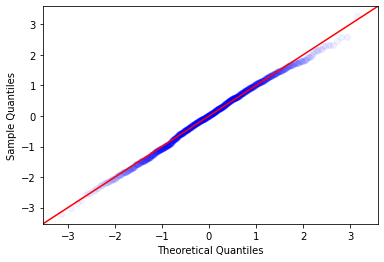

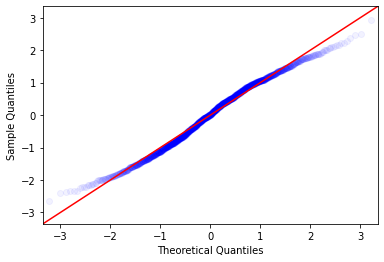

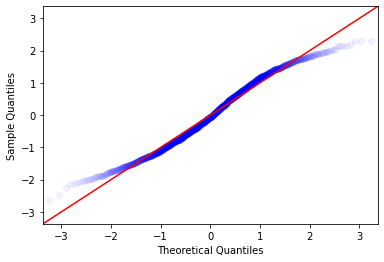

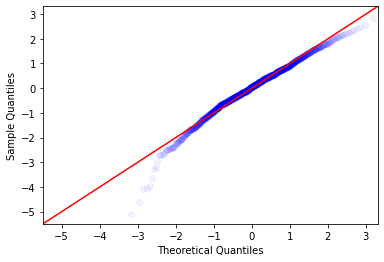

In [587]:
for name, tier, income in price_tiers:
    print(name.upper())
    make_ols(tier, income)

## Train Split Test - High Tier

In [454]:
#first step
high_data = hightier[['price', 'bathrooms', 'floors', 'sqft_neighb', 
                      'sqft_habitable', 'thru2020',
                      'zip006t011', 'zip107t115',
                      'zip116t122', 'zip177t199', 
                      'mi_2_scl', 'scls_in_mi', 'mi_2_rest',
                      'mi_2_groc', 'groc_in_mi']].copy()

training_data, testing_data = train_test_split(high_data, test_size=0.25, random_state=44)

In [455]:
#split columns
target = 'price'
predictive_cols = training_data.drop('price', 1).columns

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.965
Model:                            OLS   Adj. R-squared (uncentered):              0.965
Method:                 Least Squares   F-statistic:                              2721.
Date:                Sun, 13 Dec 2020   Prob (F-statistic):                        0.00
Time:                        22:56:25   Log-Likelihood:                         -18305.
No. Observations:                1379   AIC:                                  3.664e+04
Df Residuals:                    1365   BIC:                                  3.671e+04
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
bathrooms       1.299e+05   6505.247     19.967      0.000    1.17e+05    1.43e+05
floors          1.156e+05   9680.582     11.937      0.000    9.66e+04    1.35e+05
sqft_neighb       -0.0002   8.71e-05     -2.861      0.004      -0.000   -7.83e-05
sqft_habitable     0.0261      0.005      5.149      0.000       0.016       0.036
thru2020       -1.524e+05   1.24e+04    -12.309      0.000   -1.77e+05   -1.28e+05
zip006t011      5.735e+04    1.4e+04      4.100      0.000    2.99e+04    8.48e+04
zip107t115      3.518e+04   1.31e+04      2.683      0.007    9459.682    6.09e+04
zip116t122      5.478e+04   1.17e+04      4.677      0.000    3.18e+04    7.78e+04
zip177t199      1.303e+05   1.38e+04      9.428      0.000    1.03e+05    1.57e+05
mi_2_scl        1.031e+05   1.39e+04      7.423      0.000    7.58e+04     1.3e+05
scls_in_mi      2.103e+04   1624.014     12.946      0.000    1.78e+04    2.42e+04
mi_2_rest       8.013e+04   1.26e+04      6.381      0.000    5.55e+04    1.05e+05
mi_2_groc       6538.8325   3115.740      2.099      0.036     426.675    1.27e+04
groc_in_mi      9388.9098   3683.686      2.549      0.011    2162.610    1.66e+04
==============================================================================
Omnibus:                       94.518   Durbin-Watson:                   1.914
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              146.829
Skew:                          -0.535   Prob(JB):                     1.31e-32
Kurtosis:                       4.187   Cond. No.                     2.56e+08
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 2.56e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

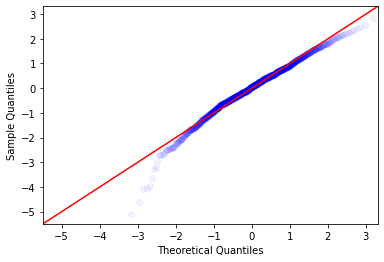

In [456]:
high_model = make_ols(hightier, predictive_cols)

In [458]:
# predictions
y_pred_train = high_model.predict(training_data[predictive_cols])
y_pred_test = high_model.predict(testing_data[predictive_cols])
# then get the scores:
train_mse = mean_squared_error(training_data[target], y_pred_train)
test_mse = mean_squared_error(testing_data[target], y_pred_test)
print('Training MSE:', train_mse, '\nTesting MSE:', test_mse)
plotcoef(high_model)

Training MSE: 19786689216.778683 
Testing MSE: 19970927110.655766


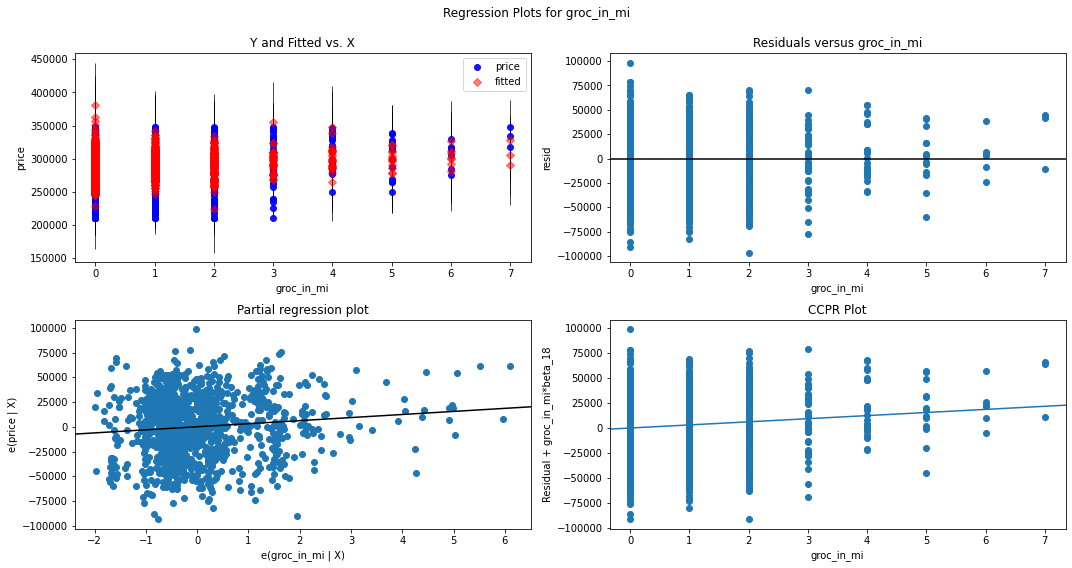

In [226]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(high_model, "groc_in_mi", fig=fig)
plt.show()

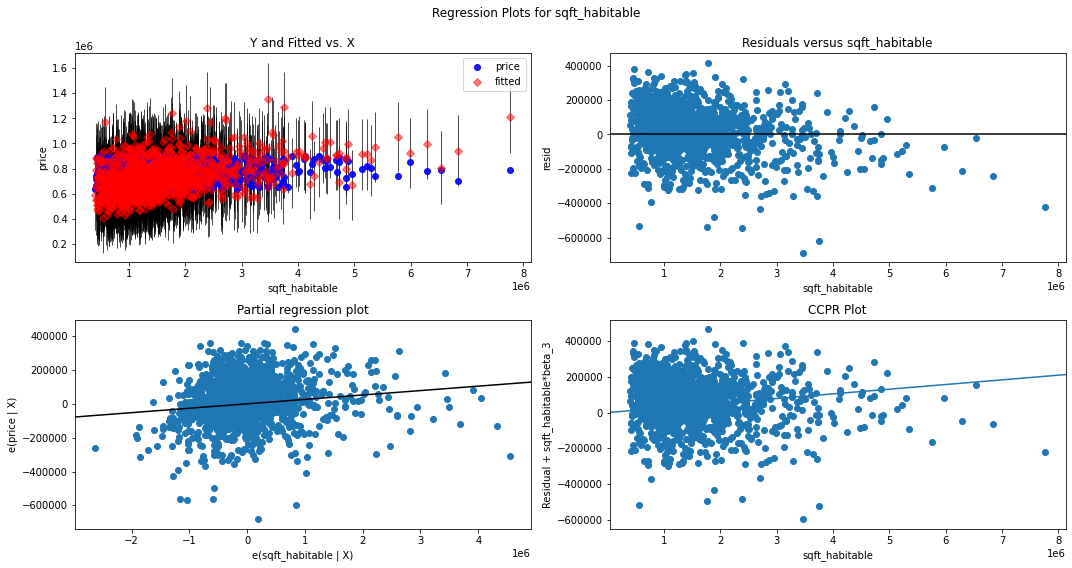

In [251]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(high_model, "sqft_habitable", fig=fig)
plt.show()

## Train Split Test - Upper Medium Tier

In [500]:
#first step
upper_med_data = uppermidtier[['bathrooms',  'lat', 'sqft_habitable',   
                               'C', 'Bmin', 'B', 'price',
                               'zip014t024', 'zip027t031', 'zip032t039', 
                               'zip070t077', 'zip125t144', 'zip146t168', 
                               'thru2000', 'thru2020', 'thru60', 'thru80']].copy()

training_data, testing_data = train_test_split(upper_med_data,test_size=0.30, random_state=55)

In [501]:
#split columns
target = 'price'
predictive_cols = training_data.drop('price', 1).columns

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.994
Model:                            OLS   Adj. R-squared (uncentered):              0.994
Method:                 Least Squares   F-statistic:                          1.195e+04
Date:                Sun, 13 Dec 2020   Prob (F-statistic):                        0.00
Time:                        23:02:18   Log-Likelihood:                         -14327.
No. Observations:                1184   AIC:                                  2.869e+04
Df Residuals:                    1168   BIC:                                  2.877e+04
Df Model:                          16                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
bathrooms       7154.1438   2659.550      2.690      0.007    1936.115    1.24e+04
lat             1.143e+04    116.568     98.081      0.000    1.12e+04    1.17e+04
sqft_habitable     0.0068      0.002      3.281      0.001       0.003       0.011
C              -1.127e+04   1.06e+04     -1.065      0.287    -3.2e+04    9487.835
Bmin            1.729e+04   3037.073      5.692      0.000    1.13e+04    2.32e+04
B                3.08e+04   5592.671      5.507      0.000    1.98e+04    4.18e+04
zip014t024     -2.961e+04   1.02e+04     -2.913      0.004   -4.96e+04   -9664.640
zip027t031     -1.144e+04   5390.363     -2.123      0.034    -2.2e+04    -868.932
zip032t039     -1.261e+04   5291.267     -2.384      0.017    -2.3e+04   -2233.227
zip070t077      -1.12e+04   5402.620     -2.072      0.038   -2.18e+04    -596.024
zip125t144     -1.312e+04   4072.725     -3.221      0.001   -2.11e+04   -5126.175
zip146t168     -1.537e+04   6400.234     -2.401      0.017   -2.79e+04   -2808.884
thru2000        -2.63e+04   5364.627     -4.903      0.000   -3.68e+04   -1.58e+04
thru2020       -2.474e+04   6239.325     -3.965      0.000    -3.7e+04   -1.25e+04
thru60         -6322.2154   4068.149     -1.554      0.120   -1.43e+04    1659.481
thru80           -2.4e+04   4176.344     -5.747      0.000   -3.22e+04   -1.58e+04
==============================================================================
Omnibus:                      139.685   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.547
Skew:                           0.056   Prob(JB):                     4.26e-09
Kurtosis:                       2.123   Cond. No.                     1.18e+07
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.18e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

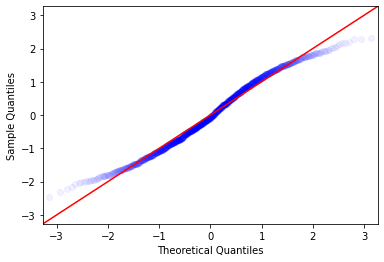

In [502]:
uppmid_model = make_ols(training_data, predictive_cols)

In [592]:
# predictions
y_pred_train = uppmid_model.predict(training_data[predictive_cols])
y_pred_test = uppmid_model.predict(testing_data[predictive_cols])
# then get the scores:
train_mse = mean_squared_error(training_data[target], y_pred_train)
test_mse = mean_squared_error(testing_data[target], y_pred_test)
print('Training MSE:', train_mse, '\nTesting MSE:', test_mse)
plotcoef(uppmid_model)

ValueError: shapes (1092,22) and (16,) not aligned: 22 (dim 1) != 16 (dim 0)

In [ ]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(uppmid_model, "sqft_habitable", fig=fig)
plt.show()

## Train Split Test - Medium Tier

In [588]:
#first step
mid_data = midtier[['bathrooms',  'lat', 'long', 
                    'sqft_habitable', 'view2', 'price', 
                    'Cpl', 'Bmin', 'B', 'Bpl',   
                    'zip006t011', 'zip014t024', 'zip032t039', 
                    'zip055t065', 'zip070t077', 'zip092t106', 
                    'zip177t199', 'rest_in_mi', 'groc_in_mi',
                    'thru2000', 'thru2020', 'thru60', 'thru80']].copy()
training_data, testing_data = train_test_split(mid_data, test_size=0.30, random_state=70)

In [589]:
#split columns
target = 'price'
predictive_cols = training_data.drop('price', 1).columns

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.993
Model:                            OLS   Adj. R-squared (uncentered):              0.993
Method:                 Least Squares   F-statistic:                          1.036e+04
Date:                Sun, 13 Dec 2020   Prob (F-statistic):                        0.00
Time:                        23:41:09   Log-Likelihood:                         -18521.
No. Observations:                1561   AIC:                                  3.709e+04
Df Residuals:                    1539   BIC:                                  3.720e+04
Df Model:                          22                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
bathrooms       6011.6770   2014.842      2.984      0.003    2059.552    9963.802
lat             7.359e+04   7872.108      9.348      0.000    5.81e+04     8.9e+04
long            2.543e+04   3068.290      8.289      0.000    1.94e+04    3.15e+04
sqft_habitable     0.0078      0.002      4.263      0.000       0.004       0.011
view2           1.377e+04   4375.178      3.147      0.002    5188.000    2.24e+04
Cpl             8660.5119   3823.641      2.265      0.024    1160.414    1.62e+04
Bmin            2.319e+04   4260.868      5.443      0.000    1.48e+04    3.16e+04
B               3.573e+04   6977.245      5.121      0.000     2.2e+04    4.94e+04
Bpl             5.675e+04   1.15e+04      4.948      0.000    3.43e+04    7.92e+04
zip006t011       1.61e+04   4015.373      4.009      0.000    8222.417     2.4e+04
zip014t024     -1.868e+04   5439.259     -3.435      0.001   -2.94e+04   -8015.040
zip032t039      1.453e+04   3243.249      4.479      0.000    8166.447    2.09e+04
zip055t065     -1.605e+04   3452.999     -4.649      0.000   -2.28e+04   -9278.269
zip070t077      1.114e+04   4271.481      2.608      0.009    2761.815    1.95e+04
zip092t106     -1.389e+04   4029.110     -3.447      0.001   -2.18e+04   -5985.807
zip177t199     -1.144e+04   3638.708     -3.143      0.002   -1.86e+04   -4300.106
rest_in_mi       648.2073    132.261      4.901      0.000     388.777     907.637
groc_in_mi     -2286.3251    900.896     -2.538      0.011   -4053.439    -519.211
thru2000       -1.737e+04   4070.207     -4.268      0.000   -2.54e+04   -9388.915
thru2020       -9762.5072   4804.642     -2.032      0.042   -1.92e+04    -338.169
thru60         -9730.4651   3414.660     -2.850      0.004   -1.64e+04   -3032.587
thru80          -1.89e+04   3604.101     -5.244      0.000    -2.6e+04   -1.18e+04
==============================================================================
Omnibus:                       95.366   Durbin-Watson:                   2.067
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               36.790
Skew:                          -0.087   Prob(JB):                     1.03e-08
Kurtosis:                       2.268   Cond. No.                     1.68e+07
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.68e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

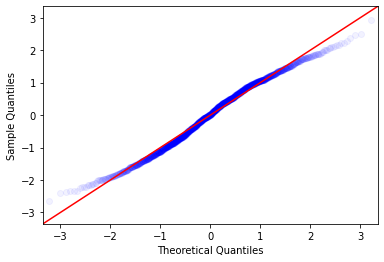

In [590]:
mid_model = make_ols(mid_data, predictive_cols)

Training MSE: 1174108957.3746374 
Testing MSE: 1203709924.776451


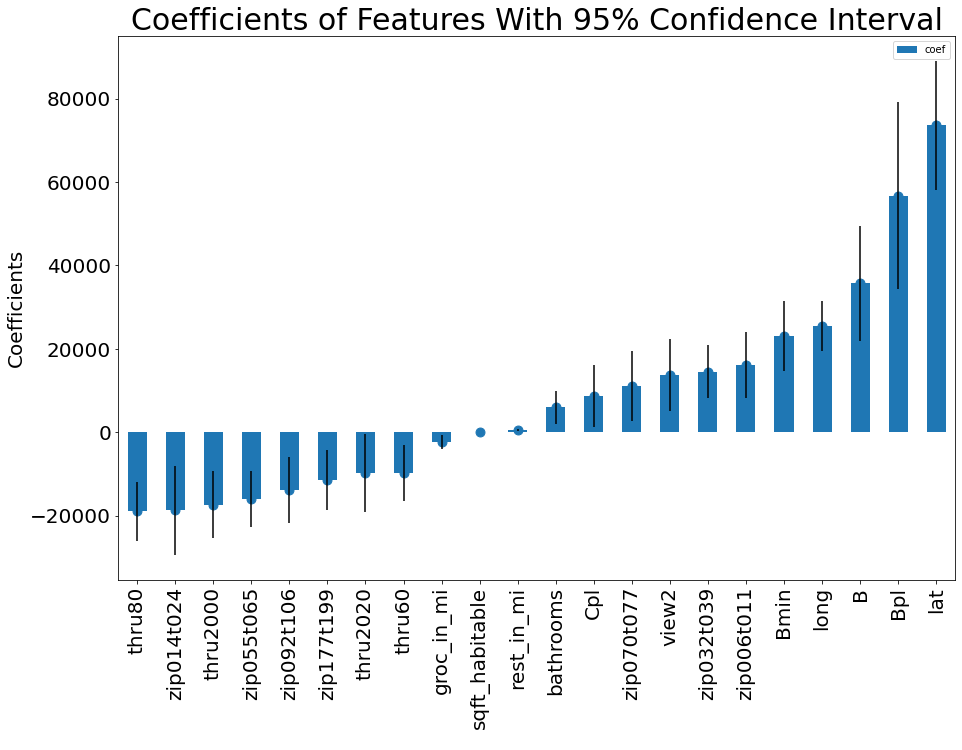

In [591]:
# predictions
y_pred_train = mid_model.predict(training_data[predictive_cols])
y_pred_test = mid_model.predict(testing_data[predictive_cols])
# then get the scores:
train_mse = mean_squared_error(training_data[target], y_pred_train)
test_mse = mean_squared_error(testing_data[target], y_pred_test)
print('Training MSE:', train_mse, '\nTesting MSE:', test_mse)
plotcoef(mid_model)

In [ ]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(high_model, "sqft_habitable", fig=fig)
plt.show()

## Train Split Test - Low Tier

In [555]:
#first step
low_data = lowtier[['bathrooms', 'waterfront', 'lat', 'long',
                    'sqft_total', 'sqft_habitable', 
                    'view1', 'view2', 'view3', 
                    'C', 'Cpl', 'Bmin', 'B', 'price',
                    'zip040t053', 'zip055t065', 'zip092t106', 
                    'zip107t115', 'zip146t168', 
                    'groc_in_mi']].copy()

training_data, testing_data = train_test_split(low_data, test_size=0.25, random_state=66)

In [556]:
#split columns
target = 'price'
predictive_cols = training_data.drop('price', 1).columns

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.989
Model:                            OLS   Adj. R-squared (uncentered):              0.989
Method:                 Least Squares   F-statistic:                              5956.
Date:                Sun, 13 Dec 2020   Prob (F-statistic):                        0.00
Time:                        23:06:36   Log-Likelihood:                         -14113.
No. Observations:                1203   AIC:                                  2.826e+04
Df Residuals:                    1185   BIC:                                  2.835e+04
Df Model:                          18                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
bathrooms       6685.2849   1789.688      3.735      0.000    3173.975    1.02e+04
waterfront      5.107e-05    7.1e-06      7.192      0.000    3.71e-05     6.5e-05
lat             1.117e+05   8057.908     13.862      0.000    9.59e+04    1.28e+05
long            4.168e+04   3126.918     13.330      0.000    3.55e+04    4.78e+04
sqft_total         0.0002   5.22e-05      4.787      0.000       0.000       0.000
sqft_habitable     0.0148      0.002      5.936      0.000       0.010       0.020
view1           2.894e+04   9241.758      3.132      0.002    1.08e+04    4.71e+04
view2           1.158e+04   5318.252      2.177      0.030    1143.458     2.2e+04
view3           2.573e+04   1.02e+04      2.522      0.012    5712.425    4.57e+04
C               3.192e+04    1.4e+04      2.279      0.023    4435.039    5.94e+04
Cpl              4.32e+04   1.37e+04      3.152      0.002    1.63e+04    7.01e+04
Bmin            5.752e+04   1.39e+04      4.140      0.000    3.03e+04    8.48e+04
B               6.565e+04   1.79e+04      3.661      0.000    3.05e+04    1.01e+05
zip040t053     -1.064e+04   4126.293     -2.578      0.010   -1.87e+04   -2540.778
zip055t065      1.618e+04   2745.268      5.895      0.000    1.08e+04    2.16e+04
zip092t106      9966.5253   3857.924      2.583      0.010    2397.402    1.75e+04
zip107t115      2.381e+04   5711.167      4.169      0.000    1.26e+04     3.5e+04
zip146t168      7588.0355   2974.927      2.551      0.011    1751.323    1.34e+04
groc_in_mi      3099.8130    835.577      3.710      0.000    1460.438    4739.188
==============================================================================
Omnibus:                        8.928   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.012   Jarque-Bera (JB):                7.871
Skew:                          -0.139   Prob(JB):                       0.0195
Kurtosis:                       2.718   Cond. No.                     1.34e+19
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The smallest eigenvalue is 5.01e-21. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

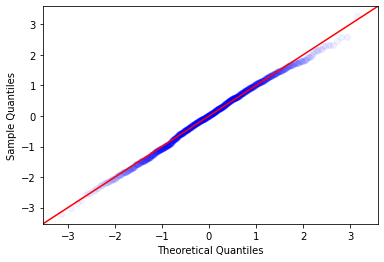

In [557]:
model = make_ols(low_data, predictive_cols)

In [558]:
# predictions
y_pred_train = model.predict(training_data[predictive_cols])
y_pred_test = model.predict(testing_data[predictive_cols])
# then get the scores:
train_mse = mean_squared_error(training_data[target], y_pred_train)
test_mse = mean_squared_error(testing_data[target], y_pred_test)
print('Training MSE:', train_mse, '\nTesting MSE:', test_mse)
plotcoef(low_model)

Training MSE: 912877759.7470982 
Testing MSE: 890508475.1377867


In [ ]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(high_model, "sqft_habitable", fig=fig)
plt.show()

# INTERPRET

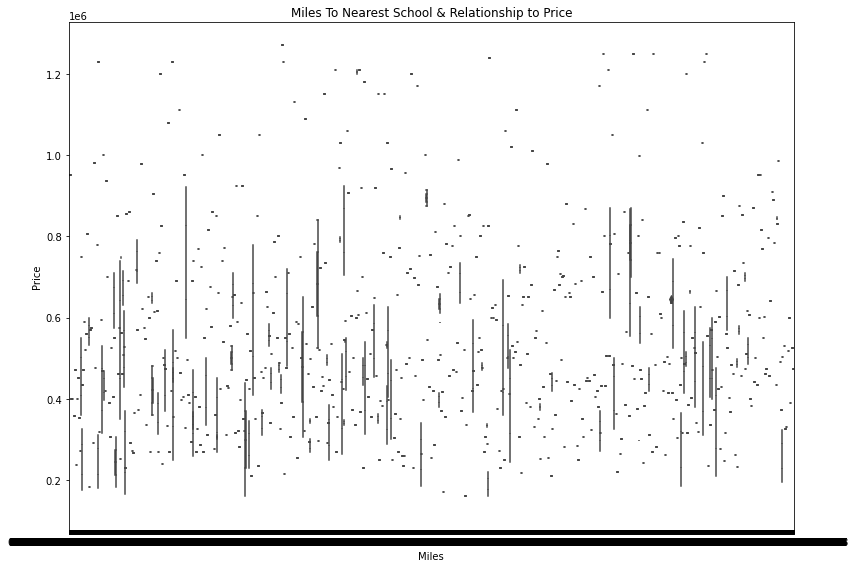

In [593]:
fig, ax = plt.subplots(figsize=(12,8))

sns.boxplot(x='mi_2_scl', y='price', data=kc_data)
ax.set(title='Miles To Nearest School & Relationship to Price', 
       xlabel='Miles', ylabel='Price')

fig.tight_layout()

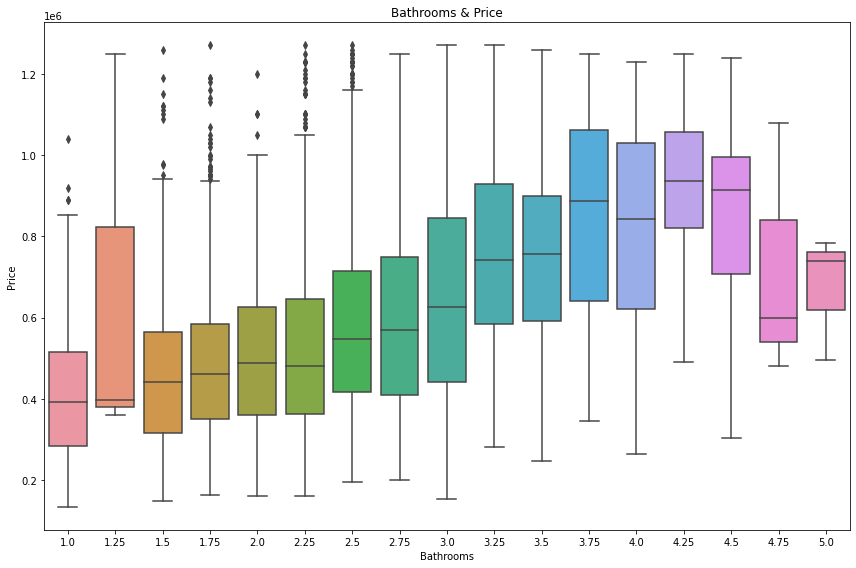

In [560]:
fig, ax = plt.subplots(figsize=(12,8))

sns.boxplot(x='bathrooms', y='price', data=kc_data)
ax.set(title='Bathrooms & Price', 
       xlabel='Bathrooms', ylabel='Price')

fig.tight_layout()

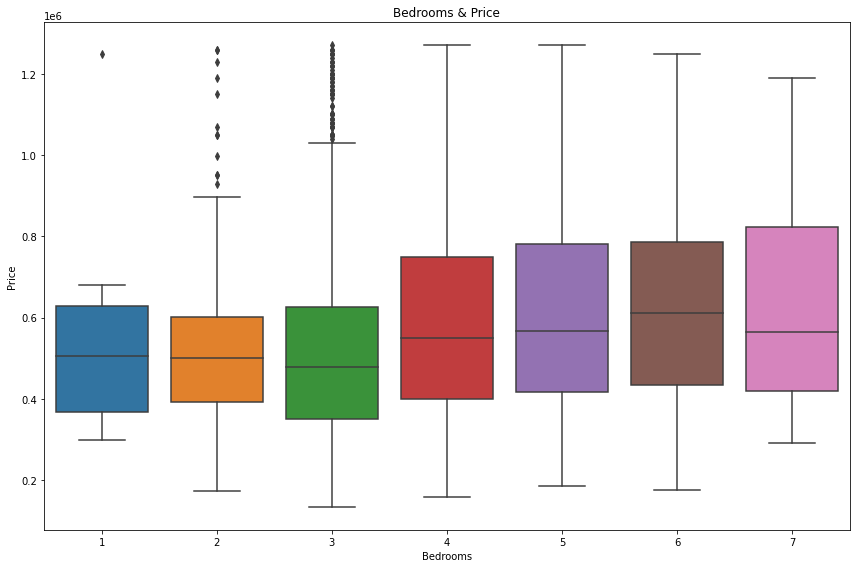

In [561]:
fig, ax = plt.subplots(figsize=(12,8))

sns.boxplot(x='bedrooms', y='price', data=kc_data)
ax.set(title='Bedrooms & Price', 
       xlabel='Bedrooms', ylabel='Price')

fig.tight_layout()

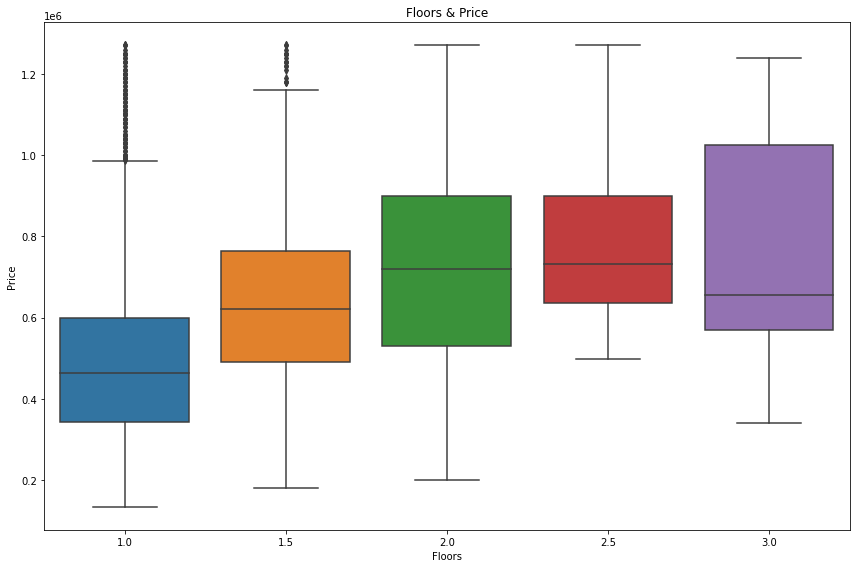

In [562]:
fig, ax = plt.subplots(figsize=(12,8))

sns.boxplot(x='floors', y='price', data=kc_data)
ax.set(title='Floors & Price', 
       xlabel='Floors', ylabel='Price')

fig.tight_layout()

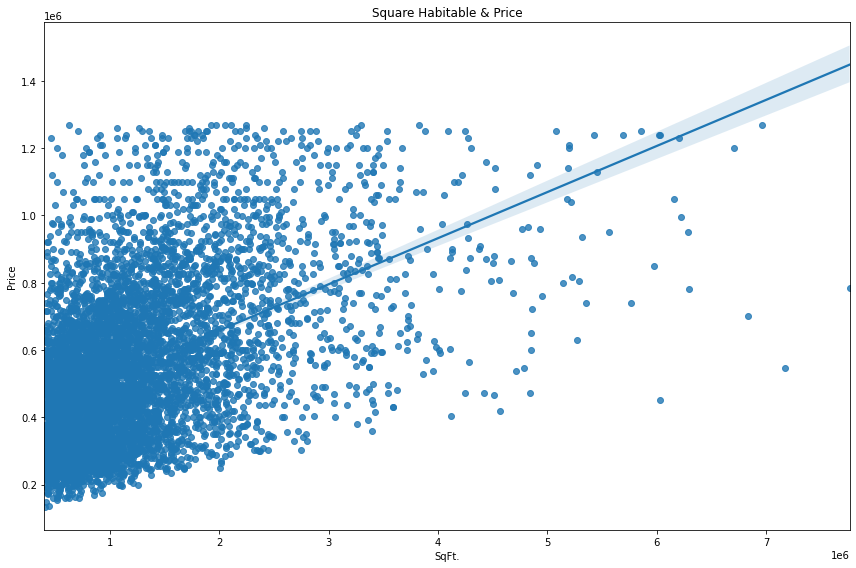

In [72]:
fig, ax = plt.subplots(figsize=(12,8))

sns.regplot(x='sqft_habitable', y='price', data=kc_data)
ax.set(title='Square Habitable & Price', 
       xlabel='SqFt.', ylabel='Price')

fig.tight_layout()

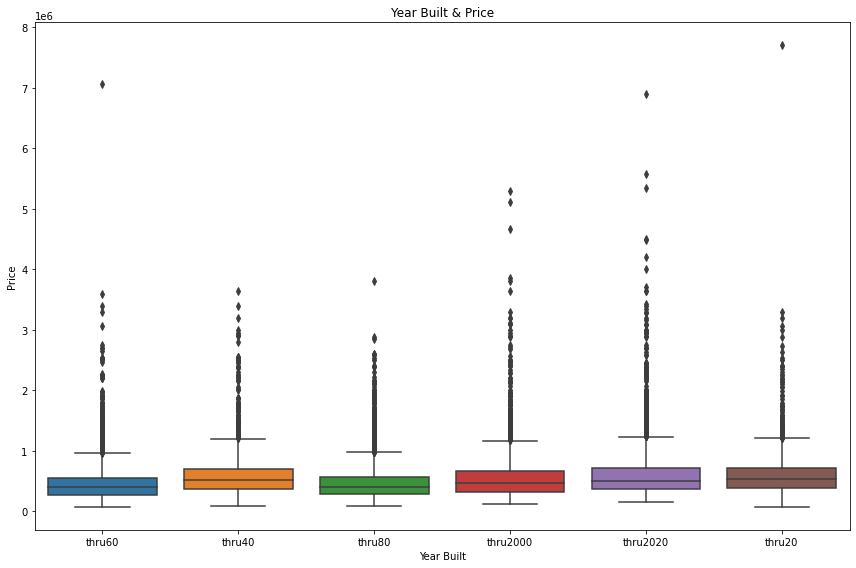

In [73]:
fig, ax = plt.subplots(figsize=(12,8))

sns.boxplot(x='yr_built', y='price', data=all_data)
ax.set(title='Year Built & Price', 
       xlabel='Year Built', ylabel='Price')

fig.tight_layout()

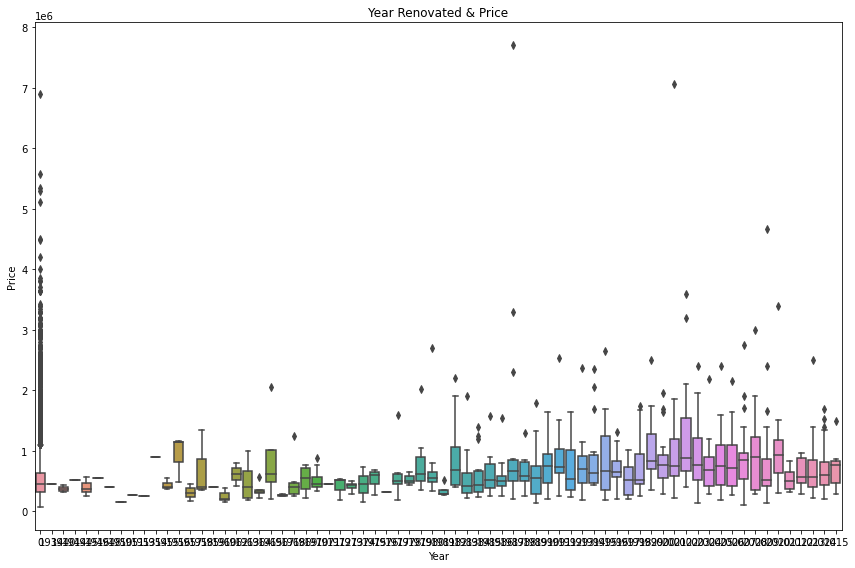

In [74]:
fig, ax = plt.subplots(figsize=(12,8))

sns.boxplot(x='yr_renovated', y='price', data=all_data)
ax.set(title='Year Renovated & Price', 
       xlabel='Year', ylabel='Price')

fig.tight_layout()

## Conclusions & Recommendations

conclusion:
distance to schools? doesn't play a factor until you're in the higher price ranges, if you're a family looking in a low/medium price range, you can aim to be closer to schools without it affecting how much you'll be paying
location location location 

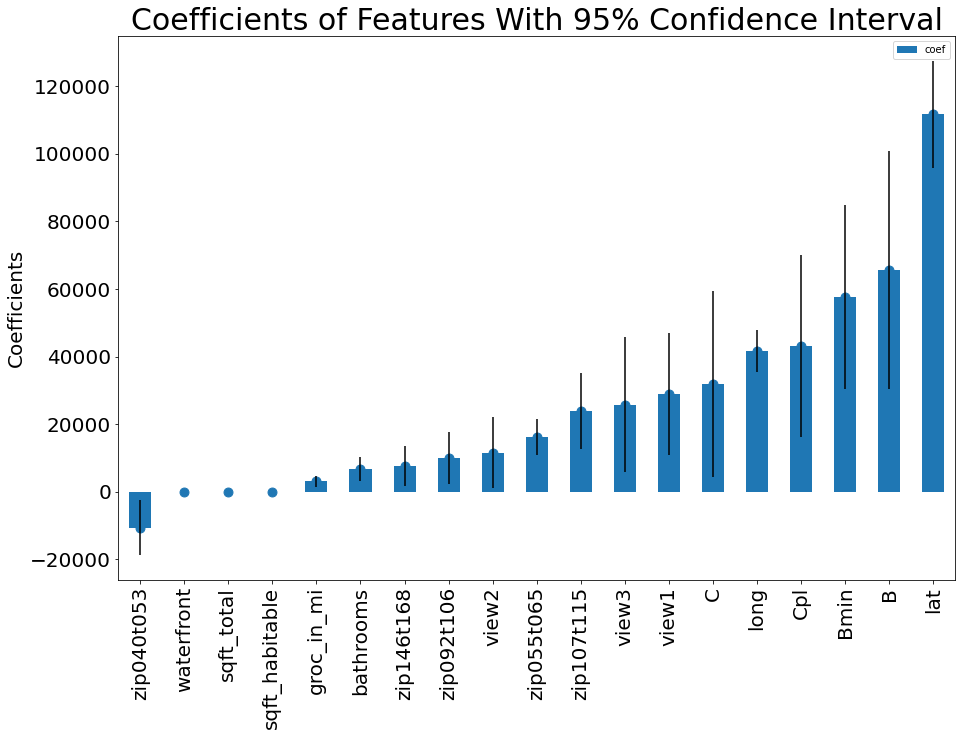